# Практическое задание к уроку "Сегментация изображений (Pytorch)"

In [1]:
!pip install segmentation_models_pytorch

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import segmentation_models_pytorch as smp

In [3]:
DATA_ROOT = './data'
MASK_ROOT = './mask'
PROCESSED_MASK_ROOT = './mask_processed'
META_FILEPATH = './list.csv'

### Загрузим мета информацию из файла

In [4]:
meta = pd.read_csv(META_FILEPATH)

In [5]:
meta

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png
...,...,...,...,...,...,...,...,...,...
28589,image00028590.jpg,1280,720,Lips,657,347,817,450,mask00028590.png
28590,image00028591.jpg,1280,720,Lips,713,325,884,388,mask00028591.png
28591,image00028592.jpg,1280,720,Lips,659,401,808,488,mask00028592.png
28592,image00028593.jpg,1280,720,Lips,689,334,839,431,mask00028593.png


### Просмотрим одно из изображений датасета

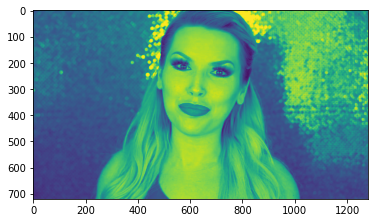

In [6]:
img = plt.imread(DATA_ROOT + '/image00000005.jpg')
plt.imshow(img[..., 0]);

### И маску к нему

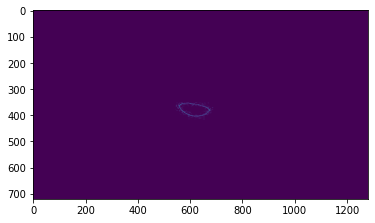

In [7]:
img = plt.imread(MASK_ROOT + '/mask00000005.png')
plt.imshow(img[..., 0]);

In [8]:
meta['class'].value_counts()

Lips    28594
Name: class, dtype: int64

В датасете один класс, все объекты принадлежат этому классу

### Оформим датасет pytorch

In [9]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

In [10]:
labels = ['Unlabeled','Lips']

class LibsDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # Подаем наш подготовленный датафрейм
        self.data = data
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data.index)
        self.class_values = [0, 1]
        self.preprocessing = preprocessing
        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значений
        img = cv2.cvtColor(cv2.imread(os.path.join(DATA_ROOT, self.image_arr[index])), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            # Нормализуем изображение в значениях [0, 1]
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        
        # считаем сегментированную картинку
        masks = []
        mask_image_path = os.path.join(MASK_ROOT, self.label_arr[index])
        mask = cv2.cvtColor(cv2.imread(mask_image_path), cv2.COLOR_BGR2RGB)
        
        cls_mask = np.where(mask == 1, 255, 0)
        cls_mask = cls_mask.astype('float')
        cls_mask = cv2.resize(cls_mask, (256, 256))

        masks.append(cls_mask[:,:,0] / 255)
            
        masks = torch.as_tensor(masks, dtype=torch.uint8)    
        
        return (img.float(), masks)

    def __len__(self):
        return self.data_len

In [11]:
df = meta.drop(columns=[    
    "width",
    "height",
    "class",
    "xmin",
    "ymin",
    "xmax",
    "ymax"
])
df

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png
...,...,...
28589,image00028590.jpg,mask00028590.png
28590,image00028591.jpg,mask00028591.png
28591,image00028592.jpg,mask00028592.png
28592,image00028593.jpg,mask00028593.png


### === Этот блок выполняется один раз ===

In [12]:
# broken_mask_indexes = []
# for index, mask in enumerate(df['mask']):
#     try:
#         mask_image_path = mask_image_path = os.path.join(PROCESSED_MASK_ROOT, mask)
#         cv2.cvtColor(cv2.imread(mask_image_path), cv2.COLOR_BGR2RGB)
#     except Exception:
#         broken_mask_indexes.append(index)
# broken_mask_indexes

In [13]:
# from numpy import savetxt
# savetxt('broken_mask_indexes.csv', broken_mask_indexes, delimiter=',')

### ==================================

In [14]:
from numpy import loadtxt
broken_mask_indexes = loadtxt('broken_mask_indexes.csv', delimiter=',')

In [15]:
for index in broken_mask_indexes:
    df = df.drop(index=index)

### === Этот блок выполняется один раз ===

In [16]:
# mask_list = []
# for dirname, _, filenames in os.walk(MASK_ROOT):
#     for filename in filenames:
#         mask_list.append(filename)
# mask_list

In [17]:
# # Преобразование маски в монохромное изображение
# def mask_b(filename, save_path):
#     mask = cv2.imread(os.path.join(MASK_ROOT, filename), cv2.IMREAD_GRAYSCALE)
#     (thresh, mask_binary) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
    
#     cv2.imwrite(os.path.join(save_path, filename), mask_binary)
#     return os.path.join(save_path, filename)

In [18]:
# for path in df['mask']:
#     mask_b(path, './mask_processed')

### ==================================

<ipython-input-10-9ffb4b22f242>:44: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


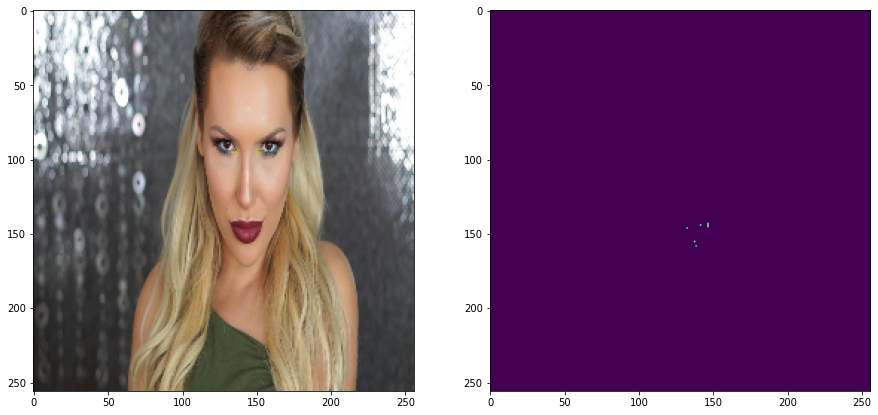

In [19]:
dataset = LibsDataset(df)
img, masks = dataset[0]
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0))
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = LibsDataset(X_train)
test_data = LibsDataset(X_test)

In [21]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True
)

In [22]:
import torch
import torch.nn as nn

def conv_block(in_channels,  out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_channels),
        nn.Conv2d(out_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_channels)
    )
    return conv

In [23]:
model = smp.Unet(classes=1)

### Обучим модель

In [24]:
learning_rate = 0.001
epochs = 1

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [26]:
sample = (next(iter(train_data_loader)))
sample[1].shape

<ipython-input-10-9ffb4b22f242>:44: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


torch.Size([8, 1, 256, 256])

In [27]:
out = model(sample[0].to(device))
out.shape

torch.Size([8, 1, 256, 256])

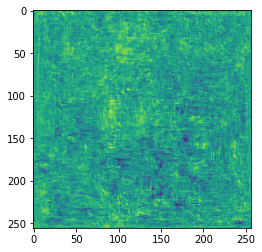

In [28]:
plt.imshow(out[0][0].detach().cpu());

In [29]:
optimizer = torch.optim.Adam(model.parameters())

In [30]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = logits
        m1 = probs.reshape(num, -1)
        m2 = targets.reshape(num, -1)
        intersection = (m1 * m2)

        score = (2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - (score.sum() / num)
        return score

In [31]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

1 epochs, 2498 total_steps per epoch


In [32]:
criterion = DiceLoss()

In [33]:
#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time

# запускаем главный тренировочный цикл
epoch_losses = []
for epoch in range(epochs):
    start_time = time.time()
    epoch_loss = []
    
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        data, labels = data.to(device), labels.to(device)        
        
        optimizer.zero_grad()
        outputs = model(data)                

        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
        if batch_idx % 50 == 0:
            print(f'batch index : {batch_idx} | loss : {loss.item()}')

    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    end_time = time.time()
    print(f'Spend time for 1 epoch: {start_time - end_time} sec')
    
    epoch_losses.append(epoch_loss)

<ipython-input-10-9ffb4b22f242>:44: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


batch index : 0 | loss : 0.9996930360794067
batch index : 50 | loss : 0.9992689490318298
batch index : 100 | loss : 0.9996897578239441
batch index : 150 | loss : 0.9999380111694336
batch index : 200 | loss : 1.00020170211792
batch index : 250 | loss : 0.9997978806495667
batch index : 300 | loss : 0.9999623894691467
batch index : 350 | loss : 1.0000065565109253
batch index : 400 | loss : 0.9999808073043823
batch index : 450 | loss : 1.00033438205719
batch index : 500 | loss : 0.9997971653938293
batch index : 550 | loss : 0.9999247193336487
batch index : 600 | loss : 0.9999505281448364
batch index : 650 | loss : 0.9994826316833496
batch index : 700 | loss : 0.9999383091926575
batch index : 750 | loss : 0.9997063875198364
batch index : 800 | loss : 1.0000048875808716
batch index : 850 | loss : 0.9999862909317017
batch index : 900 | loss : 1.0000070333480835
batch index : 950 | loss : 0.9999296069145203
batch index : 1000 | loss : 0.9998285174369812
batch index : 1050 | loss : 0.9995626211

In [34]:
save_model_path = './Unet_Model_dice_loss.pth'